In [10]:
from skimage.feature import register_translation
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy
import tensorflow as tf
from sopt.examples.utils import NearFieldPtychographySimulation
import sopt.benchmarks.ops.tensorflow.flops_registry_custom
from sopt.examples.tensorflow.near_field_ptychography.tfPtycho import CurveballPhaseRetriever
from tensorflow.python.framework import graph_util
from sopt.benchmarks.ops.tensorflow.graph_utils_custom import get_flops_for_sub_graph, get_flops_for_node_list

In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


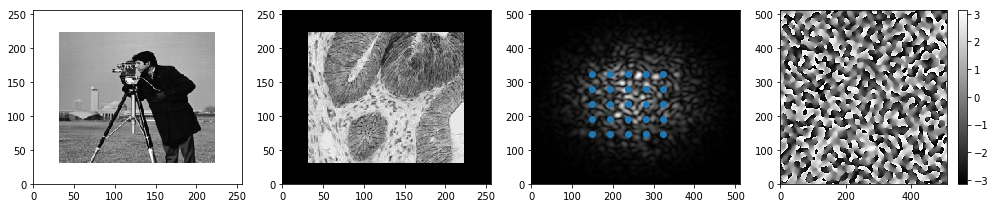

In [7]:
ptsim = NearFieldPtychographySimulation()

obj_center_positions = ptsim._positions + ptsim._obj_params.padded_npix // 2

fig, axs = plt.subplots(1, 4, figsize=[14,3])
cax0 = axs[0].pcolormesh(np.abs(ptsim._obj_padded), cmap='gray')
cax1 = axs[1].pcolormesh(np.angle(ptsim._obj_padded), cmap='gray')
cax2 = axs[2].pcolormesh(np.abs(ptsim._probe_true), cmap='gray')
axs[2].scatter(x=obj_center_positions.T[1], y=obj_center_positions.T[0])
cax3 = axs[3].pcolormesh(np.angle(ptsim._probe_true), cmap='gray')
plt.colorbar(cax3)
plt.tight_layout()
plt.show()

## Curveball - full batch

In [32]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=True)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [33]:
%%time
cb_obj_errors = []
cb_probe_errors = []
cb_losses = []
for i in tqdm(range(10000)):
    _ = pr_cb.session.run(pr_cb.obj_minimize_op)
    _ = pr_cb.session.run(pr_cb.probe_minimize_op)
    #_ = pr_cb.session.run(pr_cb._obj_clip_op)
    if i % 20 != 0: continue
    recons_obj, recons_probe, lossval = pr_cb.session.run([pr_cb._tf_obj_padded_cmplx, pr_cb._tf_probe_cmplx, pr_cb.loss_tensor])
    oshift, oerr, ophase = register_translation(recons_obj, ptsim._obj_padded, upsample_factor=10)
    oshift, oerr, ophase = register_translation(recons_obj * np.exp(-1j * ophase), ptsim._obj_padded, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe, ptsim._probe_true, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe * np.exp(-1j * pphase), ptsim._probe_true, upsample_factor=10)
    cb_obj_errors.append(oerr)
    cb_probe_errors.append(perr)
    cb_losses.append(lossval)
    if i % 100 == 0: print(i, lossval, oerr, perr)
    if oerr < 0.04: break

0 5061422600.0 0.5736167454802094 0.998429053492764
100 183563620.0 0.3931430895241434 0.9967567848836989
200 116421416.0 0.22738905699818382 0.9956754936040743
300 64790440.0 0.2530818268525777 0.994627365938528
400 43733356.0 0.31845975453202674 0.9895081107016345
500 33916780.0 0.27502305796320503 0.9909081019618566
600 21850522.0 0.3052641856483405 0.9936358823557786
700 17179270.0 0.32898676615205136 0.9925833591906178
800 15832238.0 0.28938621204060366 0.9919329162135151
900 14786730.0 0.28588762080978114 0.9914848676382086
1000 13909582.0 0.2605834970593553 0.991184423130765
1100 13049176.0 0.24502526911358166 0.9909455462860823
1200 12193040.0 0.2268599979041945 0.9907316394263976
1300 11356976.0 0.21254520537324817 0.9895105606512803
1400 10566676.0 0.19935343832049707 0.9883742805978307
1500 9849912.0 0.18704051073042616 0.9875604883289395
1600 9198879.0 0.17659176749355318 0.9870866669137941
1700 8600940.0 0.1659964650658957 0.9869581726418583
1800 8041378.5 0.15603943565513

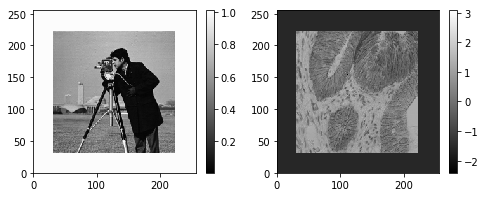

In [34]:
plt.figure(figsize=[8,3])
plt.subplot(1,2,1)
plt.pcolormesh(np.abs(recons_obj), cmap='gray')
plt.colorbar()
plt.subplot(1,2,2)
plt.pcolormesh(np.angle(np.exp(1j * (np.angle(recons_obj)  - np.pi / 2))), cmap='gray')
plt.colorbar()
plt.show()

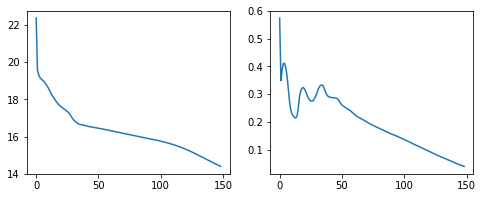

In [35]:
fig, axs = plt.subplots(1,2,figsize=[8,3])
axs[0].plot(np.log(cb_losses))
axs[1].plot(cb_obj_errors)
plt.show()

In [36]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(flops_cb_and_fwd)

24883001312


In [37]:
total_flops = i * flops_cb_and_fwd
print(total_flops)

73653683883520


In [38]:
graph_def = pr_cb.graph.as_graph_def()

In [39]:
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)
flops_damping

3443111540

In [40]:
total_flops_actual = (flops_cb_and_fwd - flops_damping) * i
print(f'total flops {total_flops_actual:4.3g}')

total flops 6.35e+13


## Curveball - minibatch 5

In [42]:
pr_cb = CurveballPhaseRetriever(ptsim=ptsim, probe_recons=True, batch_size=5)
pr_cb.setOptimizingParams()
pr_cb.initSession()

In [45]:
%%time
cb_obj_errors = []
cb_probe_errors = []
cb_losses = []
for i in tqdm(range(10000)):
    _ = pr_cb.session.run(pr_cb.obj_minimize_op)
    _ = pr_cb.session.run(pr_cb.probe_minimize_op)
    _ = pr_cb.session.run(pr_cb._assign_op)
    if i % 100 != 0: continue
    recons_obj, recons_probe, lossval = pr_cb.session.run([pr_cb._tf_obj_padded_cmplx, pr_cb._tf_probe_cmplx, pr_cb.loss_tensor])
    oshift, oerr, ophase = register_translation(recons_obj, ptsim._obj_padded, upsample_factor=10)
    oshift, oerr, ophase = register_translation(recons_obj * np.exp(-1j * ophase), ptsim._obj_padded, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe, ptsim._probe_true, upsample_factor=10)
    pshift, perr, pphase = register_translation(recons_probe * np.exp(-1j * pphase), ptsim._probe_true, upsample_factor=10)
    cb_obj_errors.append(oerr)
    cb_probe_errors.append(perr)
    cb_losses.append(lossval)
    if i % 500 == 0: print(i, lossval, oerr, perr)
    if oerr < 0.04: break

0 740172.9 0.07016616780396623 0.8706773234441132
500 760109.6 0.06562935412423716 0.8401391620562245
1000 820953.1 0.061070475999284855 0.8064661437721072
1500 594327.4 0.05656407587992101 0.7700922341933741
2000 544863.75 0.05265013527609012 0.7317293584903317
2500 512702.44 0.04859111168267682 0.6913096030216632
3000 634344.5 0.04504248371074032 0.6502501539095933
3500 429421.84 0.04176213520913316 0.6094682852286716
CPU times: user 17min 15s, sys: 1min 45s, total: 19min
Wall time: 3min 55s


In [46]:
with pr_cb.graph.as_default():
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()    
    flops_cb_and_fwd = tf.profiler.profile(run_meta=run_meta, cmd='scope', options=opts) 
    flops_cb_and_fwd = flops_cb_and_fwd.total_float_ops
    print(flops_cb_and_fwd)

4617064784


In [48]:
total_flops = (i + 20000) * flops_cb_and_fwd
print(total_flops)

109886141859200


In [49]:
graph_def = pr_cb.graph.as_graph_def()

In [50]:
# To calculate the flops required for one curveball step,
# I am isolating the nodes involved in the damping update.
# Removing this should give me the flops required per step.
# The damping update only happens every 5 steps (by default),
# so I don't want to include it in the default flops value for
# curveball.
nodes_damping = [node for node in graph_def.node if 'damping_update' in node.name]
flops_damping = get_flops_for_node_list(pr_cb.graph, nodes_damping)
flops_damping

627754372

In [51]:
total_flops_actual = (flops_cb_and_fwd - flops_damping) * (i + 20000)
print(f'total flops {total_flops_actual:4.3g}')

total flops 9.49e+13
